# Medidrop: Weather and Terrain

## Weather Data with OpenWeatherMap

In [1]:
!pip install sentinelhub matplotlib shapely numpy Pillow

In [2]:
# File: credentials.py
with open("API_key_openweather.py", "r") as f:
    weather_api_key = f.read().strip()

# Sentinel Hub OAuth
from OAuth_sentinel import client_id, client_secret

In [3]:
# Simulate input from dashboard
lat = float(input("Enter latitude: "))     # Example: 50.250
lon = float(input("Enter longitude: "))    # Example: 5.667

#Belgium, in the Wallonia region, near the Ardennes.

Enter latitude:  50.250
Enter longitude:  5.667


In [11]:
import requests
from datetime import datetime

weather_url = (
    f"https://api.openweathermap.org/data/2.5/weather"
    f"?lat={lat}&lon={lon}&appid={weather_api_key}&units=metric"
)

response = requests.get(weather_url)
weather_data = response.json()

if response.status_code == 200 and "main" in weather_data:
    weather_info = {
        "location": {"lat": lat, "lon": lon},
        "timestamp": datetime.utcfromtimestamp(weather_data["dt"]).isoformat() + "Z",
        "wind_speed": weather_data["wind"]["speed"],
        "wind_direction": weather_data["wind"]["deg"],
        "temperature": weather_data["main"]["temp"],
        "precipitation": weather_data.get("rain", {}).get("1h", 0.0),
        "visibility": weather_data.get("visibility", None),
        "cloud_cover": weather_data["clouds"]["all"],
        "humidity": weather_data["main"]["humidity"],
        "storm_warning": weather_data["weather"][0]["main"].lower() in ["thunderstorm"]
    }

    print("✅ Weather Info:")
    print(weather_info)
else:
    print("❌ Failed to get weather info")

✅ Weather Info:
{'location': {'lat': 50.25, 'lon': 5.667}, 'timestamp': '2025-05-17T17:10:00Z', 'wind_speed': 2.68, 'wind_direction': 344, 'temperature': 13.49, 'precipitation': 0.0, 'visibility': 10000, 'cloud_cover': 51, 'humidity': 55, 'storm_warning': False}


## Copernicus|

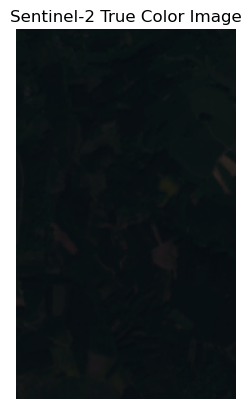

In [12]:
# Import necessary libraries
from sentinelhub import SHConfig, MimeType, CRS, BBox, SentinelHubRequest, DataCollection, bbox_to_dimensions
from matplotlib import pyplot as plt
from OAuth_sentinel import client_id, client_secret  # OAuth credentials

# Latitude and longitude should already be defined earlier like this:
# lat = float(input("Enter latitude: "))
# lon = float(input("Enter longitude: "))

# Sentinel Hub configuration
config = SHConfig()
config.sh_client_id = client_id
config.sh_client_secret = client_secret

# Define the bounding box around the selected coordinates
bbox = BBox(bbox=[lon - 0.01, lat - 0.01, lon + 0.01, lat + 0.01], crs=CRS.WGS84)
image_size = bbox_to_dimensions(bbox, resolution=10)

# Create the Sentinel Hub request
request = SentinelHubRequest(
    data_folder='satellite_images',
    evalscript="""
    //VERSION=3
    function setup() {
      return {
        input: ["B04", "B03", "B02"],
        output: { bands: 3 }
      };
    }

    function evaluatePixel(sample) {
      return [sample.B04, sample.B03, sample.B02];
    }
    """,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2025-05-01", "2025-05-17"),
        )
    ],
    responses=[
        SentinelHubRequest.output_response("default", MimeType.PNG)
    ],
    bbox=bbox,
    size=image_size,
    config=config
)

# Get the image
image = request.get_data()[0]

# Display the image
plt.imshow(image)
plt.title("Sentinel-2 True Color Image")
plt.axis("off")
plt.show()


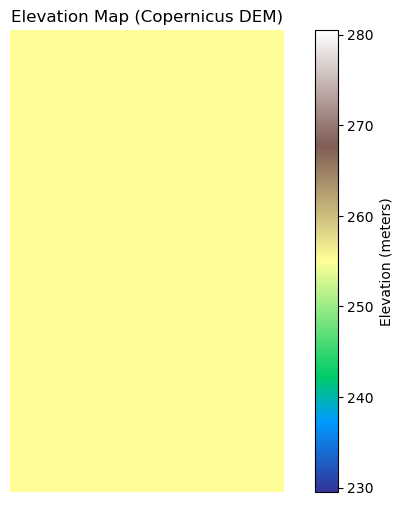

In [13]:
# === Altitude data from Copernicus DEM ===

# Define bounding box for elevation (can be same or smaller/larger)
bbox_dem = BBox(bbox=[lon - 0.01, lat - 0.01, lon + 0.01, lat + 0.01], crs=CRS.WGS84)
image_size_dem = bbox_to_dimensions(bbox_dem, resolution=30)  # 30m resolution for DEM is common

# Create request for elevation data
elevation_request = SentinelHubRequest(
    data_folder='elevation_data',
    evalscript="""
    //VERSION=3
    function setup() {
      return {
        input: ["DEM"],
        output: { bands: 1 }
      };
    }

    function evaluatePixel(sample) {
      return [sample.DEM];
    }
    """,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.define(
                name='COPERNICUS_DEM_30',
                api_id='DEM',
                service_url='https://services.sentinel-hub.com',
                collection_type='byoc'
            ),
            time_interval=("2020-01-01", "2025-01-01"),  # DEM is not time-sensitive, but a range is needed
        )
    ],
    responses=[
        SentinelHubRequest.output_response("default", MimeType.TIFF)
    ],
    bbox=bbox_dem,
    size=image_size_dem,
    config=config
)

# Get elevation data
elevation_data = elevation_request.get_data()[0]

# Display elevation
plt.figure(figsize=(8, 6))
plt.imshow(elevation_data, cmap='terrain')
plt.colorbar(label="Elevation (meters)")
plt.title("Elevation Map (Copernicus DEM)")
plt.axis("off")
plt.show()


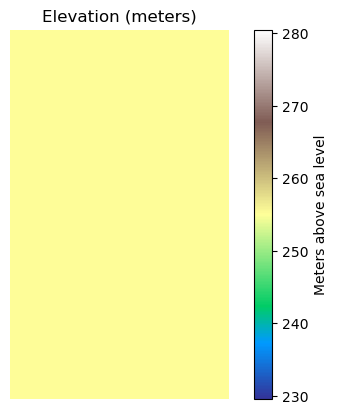

In [14]:
from sentinelhub import BBox, CRS, SentinelHubRequest, MimeType, bbox_to_dimensions, DataCollection

# Define bounding box and image size (reuse lat/lon from earlier)
bbox_dem = BBox(bbox=[lon - 0.01, lat - 0.01, lon + 0.01, lat + 0.01], crs=CRS.WGS84)
image_size_dem = bbox_to_dimensions(bbox_dem, resolution=30)  # DEM resolution is 30m

# Define DEM layer manually
copernicus_dem = DataCollection.define(
    name='COPERNICUS_DEM',
    api_id='DEM',
    service_url='https://services.sentinel-hub.com',
)

# Request DEM data
elevation_request = SentinelHubRequest(
    data_folder='elevation_data',
    evalscript="""
    //VERSION=3
    function setup() {
      return {
        input: ["DEM"],
        output: { bands: 1 }
      };
    }

    function evaluatePixel(sample) {
      return [sample.DEM];
    }
    """,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=copernicus_dem,
            time_interval=("2020-01-01", "2025-01-01"),  # DEM is not time-dependent
        )
    ],
    responses=[
        SentinelHubRequest.output_response("default", MimeType.TIFF)
    ],
    bbox=bbox_dem,
    size=image_size_dem,
    config=config
)

# Get the elevation data
elevation_data = elevation_request.get_data()[0]

# Plot it
plt.imshow(elevation_data, cmap='terrain')
plt.title("Elevation (meters)")
plt.axis("off")
plt.colorbar(label="Meters above sea level")
plt.show()


In [15]:
print("Min elevation:", elevation_data.min())
print("Max elevation:", elevation_data.max())
print("Mean elevation:", elevation_data.mean())

Min elevation: 255
Max elevation: 255
Mean elevation: 255.0


In [16]:
!pip install geojson

In [17]:
import numpy as np
import geojson
from shapely.geometry import Point, mapping

# -- Inputs --
base_lat, base_lon = 50.2500, 5.6670  # Example base location hospital in the Marche-en-Famenne area
delivery_lat, delivery_lon = lat, lon  # From your dashboard, same as your original lat/lon

# Function to convert lat/lon to pixel indices in elevation_data
def latlon_to_pixel(lat, lon, bbox, size):
    """
    Convert geographic coordinates to pixel indices in the DEM array.
    """
    min_lon, min_lat, max_lon, max_lat = bbox  # fixed this line
    
    # Calculate relative position in bbox
    x_rel = (lon - min_lon) / (max_lon - min_lon)
    y_rel = (max_lat - lat) / (max_lat - min_lat)  # Note: latitude decreases down the array
    
    # Convert relative position to pixel indices
    x_pix = int(x_rel * size[0])
    y_pix = int(y_rel * size[1])
    
    return y_pix, x_pix  # row, col

# Generate a simple straight path with N points between base and delivery
N = 20
lats = np.linspace(base_lat, delivery_lat, N)
lons = np.linspace(base_lon, delivery_lon, N)

features = []

for lat_pt, lon_pt in zip(lats, lons):
    # Convert lat/lon to pixel indices
    row, col = latlon_to_pixel(lat_pt, lon_pt, bbox_dem, image_size_dem)
    
    # Check if pixel indices are within DEM bounds
    if 0 <= row < elevation_data.shape[0] and 0 <= col < elevation_data.shape[1]:
        altitude = float(elevation_data[row, col])
    else:
        altitude = None  # Outside DEM bounds
    
    # Create GeoJSON Point feature with altitude as property
    point_geom = Point((lon_pt, lat_pt))
    feature = geojson.Feature(geometry=point_geom, properties={"altitude_m": altitude})
    features.append(feature)

# Create a FeatureCollection
feature_collection = geojson.FeatureCollection(features)

# Save GeoJSON to file
output_filename = "terrain_path.geojson"
with open(output_filename, "w") as f:
    geojson.dump(feature_collection, f)

print(f"GeoJSON with terrain altitudes saved to {output_filename}")


GeoJSON with terrain altitudes saved to terrain_path.geojson
